# Final project restart: Vivek
Import the modules, assign variables and define functions.

This is the version that I am using since I got some advice from Vivek on the forum. He is really great and added a great customized function for getting the scoring function to work better.

In [83]:
import sys
import pickle
sys.path.append("../tools/")

import pandas as pd
import numpy as np

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from sklearn.preprocessing import Imputer
                                                
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import cross_validation

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from tester import test_classifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

### Data Import
Defining functions that I will use for data import and prep.

In [84]:
data = "final_project_dataset.pkl"

In [85]:
def import_data(data):
    '''This are the things I will do to import the data everytime, 
    regardless of what variables I make.'''
    with open(data, "r") as data_file:
        data_dict = pickle.load(data_file)
    df = pd.DataFrame(data_dict)
    df = df.transpose()
    df = df.drop('email_address', axis=1)
    df = df.astype(float)
    df = df.drop('TOTAL')
    df = df.drop("THE TRAVEL AGENCY IN THE PARK")
    df = df.drop("loan_advances", axis=1)
    return df

In [86]:
def import_data1(data):
    '''This are the things I will do to import the data everytime, 
    regardless of what variables I make.'''
    with open(data, "r") as data_file:
        data_dict1 = pickle.load(data_file)
    return data_dict1

In [87]:
df1 = import_data1(data)

In [89]:
df = import_data(data)

In [135]:
def get_features_labels_new(df):
    '''This is where the features and labels are extracted to use as arguments
    for sklearn\'s cross_validation function. It is also where I will do add
    any new variables.'''
    df['deferred_ratio'] = df['deferred_income']/(df['total_payments'] + 1)
    df['pct_from_poi'] = df['from_poi_to_this_person']/(df['from_messages'] + 1)
    df['pct_to_poi'] = df['from_this_person_to_poi']/(df['from_messages'] + 1)
    df['to_from'] = df['pct_from_poi']*df['pct_from_poi']
    features_list = list(df.columns)
    features_list.remove('poi')
    features = df[features_list]
    labels = df['poi']
    return features, labels

In [136]:
def get_features_labels_drop(df):
    '''This is where the features and labels are extracted to use as arguments
    for sklearn\'s cross_validation function. It is also where I will do add
    any new variables.
    dropping director_fees, restricted_stock_preferred'''
    df = df.drop('restricted_stock_deferred', axis=1)
    df = df.drop('director_fees', axis=1)
    features_list = list(df.columns)
    features_list.remove('poi')
    features = df[features_list]
    labels = df['poi']
    return features, labels

In [137]:
def get_features_labels(df):
    '''This is where the features and labels are extracted to use as arguments
    for sklearn\'s cross_validation function. This function has no new features 
    added into the data set.'''
    features_list = list(df.columns)
    features_list.remove('poi')
    features = df[features_list]
    labels = df['poi']
    return features, labels

In [13]:
#features, labels = get_features_labels_new(df)

In [14]:
def get_train_test_split(features, labels):
    '''This gets the train test split for the sklearn runs of the model'''
    from sklearn import cross_validation
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    return features_train, features_test, labels_train, labels_test

In [15]:
features_train, features_test, labels_train, labels_test = get_train_test_split(features, labels)

NameError: name 'features' is not defined

### Analysis Functions
The functions I will call to analyze the data.

In [91]:
# code from vivek_29420285151271 to replace f1 as scoring criterion

def precision_recall(labels,predictions):
    ind_true_pos = [i for i in range(0,len(labels)) if (predictions[i]==1) & (labels[i]==1)]
    ind_false_pos = [i for i in range(0,len(labels)) if ((predictions[i]==1) & (labels[i]==0))]
    ind_false_neg = [i for i in range(0,len(labels)) if ((predictions[i]==0) & (labels[i]==1))]
    ind_true_neg = [i for i in range(0,len(labels)) if ((predictions[i]==0) & (labels[i]==0))]
    precision = 0
    recall = 0
    
    
    ind_labels = [i for i in range(0,len(labels)) if labels[i]==1]
    
    if len(ind_labels) !=0:
        if float( len(ind_true_pos) + len(ind_false_pos))!=0:
            precision = float(len(ind_true_pos))/float( len(ind_true_pos) + len(ind_false_pos))
        if float( len(ind_true_pos) + len(ind_false_neg))!=0:
            recall = float(len(ind_true_pos))/float( len(ind_true_pos) + len(ind_false_neg))
        return precision, recall
    else:
        return -1,-1

def custom_scorer(labels, predictions):
    precision,recall = precision_recall(labels,predictions)
    min_score = min(precision, recall)
    return min_score

In [92]:
def get_outcomes(grid_object):
    '''Gets the print out of all the outcomes from the grid_search. It prints out the 
    best parameters found by the model and the outcomes of the test of the model on 
    the test set.'''
    print "Best parameters from the grid search:", pprint(gridCV_object.best_params_)
    clf_gridCV = gridCV_object.best_estimator_
    print "\nBest Estimator Accuracy:", clf_gridCV.score(features_test, labels_test)
    clf_gridCV_pred = clf_gridCV.predict(features_test)
    print "\nRecall Score:", recall_score(labels_test, clf_gridCV_pred)
    print "\nPrecision Score:", precision_score(labels_test, clf_gridCV_pred)

In [93]:
def get_outcomes_whole_data_set(grid_object):
    '''Gets the print out of all the outcomes from the grid_search. It prints out the 
    best parameters found by the model and the outcomes of the test of the model on 
    the test set, but using the whole data set rather than the train-test split.'''
    print "Best parameters from the grid search:", pprint(gridCV_object.best_params_)
    clf_gridCV = gridCV_object.best_estimator_
    print "\nBest Estimator Accuracy:", clf_gridCV.score(features_test, labels_test)
    clf_gridCV_pred = clf_gridCV.predict(features)
    print "\nRecall Score:", recall_score(labels, clf_gridCV_pred)
    print "\nPrecision Score:", precision_score(labels, clf_gridCV_pred)

### Exploratory Analysis, feature engineering

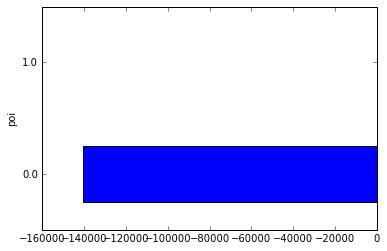

In [94]:
df.groupby('poi')['restricted_stock_deferred'].agg(np.median).plot(kind='barh')

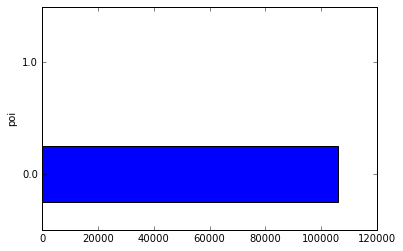

In [95]:
df.groupby('poi')['director_fees'].agg(np.median).plot(kind='barh')

So one thing I am going to do with this information is to remove the variables that are not associated in any way with the poi's. That might at least deal with the 1.0's problem. 

### Models

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer

# Get custom scorer
score = make_scorer(custom_scorer, greater_is_better=True)

# Get data, here with the features unrealated to poi dropped.
features, labels = get_features_labels_drop(df)

# Get the test-train split
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels)

# Build pipeline
Pipeline = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', StandardScaler()),
        ('pca', PCA()),
        ('clf', DecisionTreeClassifier(random_state = 53))
    ])

# Build Grid
x = [x for x in range(2,10)]
d = [d for d in range(2,4)]
param_grid = {'pca__n_components': x,
              'clf__max_depth': d,
              'imp__strategy':['most_frequent','median','mean']}

# set model parameters to grid search object
gridCV_object = GridSearchCV(estimator = Pipeline, 
                             param_grid = param_grid,
                             scoring = score,
                             cv = StratifiedShuffleSplit(labels, test_size=0.1,  n_iter=100))

# train the model
gridCV_object.fit(features, labels)

# apply model to test data, print results
get_outcomes_whole_data_set(gridCV_object)

Best parameters from the grid search:{'clf__max_depth': 3, 'imp__strategy': 'mean', 'pca__n_components': 8}
 None

Best Estimator Accuracy: 1.0

Recall Score: 0.555555555556

Precision Score: 0.909090909091


### Same model submitted to the grader: 

Start from begining

In [184]:
#import data
def import_data1(data):
    '''This are the things I will do to import the data everytime, 
    regardless of what variables I make.'''
    with open(data, "r") as data_file:
        data_dict1 = pickle.load(data_file)
    return data_dict1

df1 = import_data1(data)

In [185]:
#change to pandas data frame
df1 = pd.DataFrame(df1)
df1 = df1.transpose()
df1 = df1.drop('email_address', axis=1)
df1 = df1.astype(float)
df1 = df1.drop('TOTAL')
df1 = df1.drop("THE TRAVEL AGENCY IN THE PARK")
df1 = df1.drop("loan_advances", axis=1)
df1 = df1.drop('restricted_stock_deferred', axis=1)
df1 = df1.drop('director_fees', axis=1)
df1['deferred_ratio'] = df1['deferred_income']/(df['total_payments'] + 1)
df1['pct_from_poi'] = df1['from_poi_to_this_person']/(df['from_messages'] + 1)
df1['pct_to_poi'] = df1['from_this_person_to_poi']/(df['from_messages'] + 1)
df1['to_from'] = df1['pct_from_poi']*df['pct_from_poi']

features_list = list(df1.columns)
features_list.remove('poi')
features_list.insert(0, 'poi')

In [186]:
#change back to dictionary
df1 = df1.transpose()
df1 = df1.to_dict()

In [187]:
#features_list

In [188]:
from tester import test_classifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

clf = Pipeline([
        ('imp', Imputer(missing_values='NaN', strategy='most_frequent')),
        ('std', StandardScaler()),
        ('pca', PCA(n_components=4)),
        ('clf', DecisionTreeClassifier(random_state = 53, max_depth=2))
    ])

print "\n\nAnd these are the results going through the test classifier:\n"
test_classifier(clf, df1, features_list, folds = 1000)



And these are the results going through the test classifier:

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=4, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max...plit=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=53, splitter='best'))])
	Accuracy: 0.82467	Precision: 0.19595	Recall: 0.10150	F1: 0.13373	F2: 0.11233
	Total predictions: 15000	True positives:  203	False positives:  833	False negatives: 1797	True negatives: 12167



In [22]:
# Get data, here with the features unrealated to poi dropped.
features, labels, features_list = get_features_labels_drop(df)

data_dict = df.to_dict()

NameError: name 'df' is not defined

In [23]:
type(features_list)

NameError: name 'features_list' is not defined

In [24]:
features_list.insert(0, 'poi')

NameError: name 'features_list' is not defined

In [41]:
features_list

NameError: name 'features_list' is not defined

In [40]:

from tester import test_classifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

clf = Pipeline([
        ('imp', Imputer(missing_values='NaN', strategy='mean')),
        ('std', StandardScaler()),
        ('pca', PCA(n_components=9)),
        ('clf', DecisionTreeClassifier(max_depth=3, random_state = 53))
    ])

print "\n\nAnd these are the results going through the test classifier:\n"
test_classifier(clf, df1, features_list, folds = 1000)



And these are the results going through the test classifier:



NameError: name 'features_list' is not defined

In [27]:
data_dict['poi']

NameError: name 'data_dict' is not defined

## Results
First attempt with the new scorer. Not sure whether this is the old or the new data set. 
```

Best parameters from the grid search:{'clf__max_depth': 8, 'imp__strategy': 'median', 'pca__n_components': 9}
 None

Best Estimator Accuracy: 0.772727272727


Recall Score: 0.2


Precision Score: 0.142857142857
```
This time I am doing it with the original data set for sure. 
```

Best parameters from the grid search:{'clf__max_depth': 5,
 'imp__strategy': 'most_frequent',
 'pca__n_components': 10}
 None

Best Estimator Accuracy: 0.886363636364

Recall Score: 0.2

Precision Score: 0.5
```
With the original data in the data set we seem to do a little better than with the new, created variables. Precision seems to be a lot better with the original, untreated data. 
 
I am running it one more time with \_new data just to make sure that was the problem. 
```
Best parameters from the grid search:{'clf__max_depth': 9, 'imp__strategy': 'median', 'pca__n_components': 4}
 None

Best Estimator Accuracy: 0.818181818182

Recall Score: 0.2

Precision Score: 0.2
```
Ok, that is not exactly the result we got before but it still shows the data with additional data to perform less well. 

Also, have to run Vivek's suggestion of limiting the depth of the trees to 2 or 3 or setting a minimum sample split because there is so little data. So here is one more time with the max depth set lower. That should not increase the preformance of the model (since our scoring features is selecting the model that performs the best) but it might provide some insight. Also, again following Vivek's suggestion, I will limit the principle component analysis to 10. 
```
Best parameters from the grid search:{'clf__max_depth': 3, 'imp__strategy': 'most_frequent', 'pca__n_components': 3}
 None

Best Estimator Accuracy: 0.75

Recall Score: 0.2

Precision Score: 0.125
```
Yeah, not such hot performance but at least is makes more sense. 

Now I am going to see if the model can work better with the two variables that have no association with the dependent variable, the 'drop' data set. 
```

Best parameters from the grid search:{'clf__max_depth': 3, 'imp__strategy': 'most_frequent', 'pca__n_components': 6}
 None

Best Estimator Accuracy: 0.977272727273

Recall Score: 1.0

Precision Score: 0.833333333333
```
Now, with that as a base line lets see if the Robust Scaler works better. 
```

Best parameters from the grid search:{'clf__max_depth': 3, 'imp__strategy': 'most_frequent', 'pca__n_components': 7}
 None

Best Estimator Accuracy: 0.909090909091

Recall Score: 0.2

Precision Score: 1.0
```
Ok, this is a lot worse. In fact, it is so much worse that I can't believe these results are correct. I must have changed something other than the just the scaler. 

These are the results with the two 0 poi variables dropped and the grid search run on the whole data set. 
```
Best parameters from the grid search:{'clf__max_depth': 2, 'imp__strategy': 'most_frequent', 'pca__n_components': 8}
 None

Best Estimator Accuracy: 0.909090909091

Recall Score: 0.444444444444

Precision Score: 0.888888888889
```




## Results with 1000, 10 and 100 iterations

### 1000 iterations
So the first outcome from the model is pretty good. It is StratifiedShuffleSplit with 1000 iterations. The outcome was really good but it took forever. 

```
Best parameters from the grid search:{'clf__max_depth': 9, 'pca__n_components': 10}
 None

Best Estimator Accuracy: 0.886363636364


Recall Score: 0.6


Precision Score: 0.5
```
### 10 iterations
This is great but I just can't use this for testing things out. It will take forever. So, I am going to try it with 10 iterations and see what happens. 

```

Best parameters from the grid search:{'clf__max_depth': 9, 'pca__n_components': 12}
 None

Best Estimator Accuracy: 0.863636363636


Recall Score: 0.4


Precision Score: 0.4
```
### 100
Now we get the same depth but 12 instead of 10 principle components. The scores have gone down though. It is worth trying it at a higher number of iterations. I am going to try 100. Here is the outcome: 
```
Best Estimator Accuracy: 0.818181818182


Recall Score: 0.4


Precision Score: 0.285714285714
```
Ok, so 100 iterations is worse than either 1000 or 10 iterations. That is kind of distressing. It would be nice if the behavior of the model was 'monotonic', that is, the more of one thing you do the more of something you are looking for you get. I was thinking that 100 iterations could serve as a good way to explore possibilities and narrow the search space while reserving 1000 iteration runs to make the final cut. Now I am not quite sure what to do. 

And here is another thing. I just ran the model again with 1000 iterations with the single addition of the clf's criterion being 'gini' or 'entropy'. It came back with gini as the better criterion. And the model had performance that was just as good as before on the 1000 iterations. In fact, the three scores of interest--accuracy, precision and recall--were exactly the same. But it found a max depth of 7 instead of 9. 
```
Best parameters from the grid search:{'clf__criterion': 'gini', 'clf__max_depth': 7, 'pca__n_components': 10}
 None

Best Estimator Accuracy: 0.886363636364


Recall Score: 0.6


Precision Score: 0.5
```
The reason that is so puzzling to me is that gini is the default scoring criterion for the model. So it was using gini before when it found the best preformance was at max depth of 9 instead of 7. How does that happen?

### Adding variables

In this iteration I try adding some new variables and the choice between the median and most_frequent imputation for the missing values. I also limited the search space for 'max_depth' and the number of components to 6-8 and 8-12 respectively. That may have been a mistake because I had found that the most effective max depth was 9. I don't know why I did that. 
```

Best parameters from the grid search:{'clf__max_depth': 7, 'imp__strategy': 'most_frequent', 'pca__n_components': 8}
 None

Best Estimator Accuracy: 0.886363636364


Recall Score: 0.2


Precision Score: 0.5
```
The results are strange in that adding more variables decreased the preformance, but I can't be sure that it wasn't because of my odd choice of cutting off the max_depth at 8 instead of 9. 

Also, I don't know why the max_depth is a useful parameter since the default is None. How could limiting the parameter improve preformance? 

## New Variables with modified parameter search space

Just to satisfy my curiosity I am going to increase the max_depth parameter to 10 and raise the maximum number of principle components to 16 to account for the four newly added variables.

#### Civil Libertarian Improvement

So this turns out to have been a good idea. I have had a slight loss in recall but big gains in accuracy and precision. Given that I am a civil libertarian I personally feel this is an improvement. 

```

Best parameters from the grid search:{'clf__max_depth': 8, 'imp__strategy': 'most_frequent', 'pca__n_components': 8}
 None

Best Estimator Accuracy: 0.909090909091


Recall Score: 0.4


Precision Score: 0.666666666667
```
Now I have one problem with these results in that the number of principle components chosen was at the bottom of the range I had specified. So now I have to face the possibility that there was better preforming model with a smaller dimensional principle component space that was over looked by the paramters to which I limited the grid search. So, as a double check, I am going to let the space searced go down. I am also going to keep the 'most_frequent' strategy and not search that space anymore. 

### Fewer dimensions: Insanity

Ok, this is the kind of insane behavior that is driving me insane. 
```

Best parameters from the grid search:{'clf__max_depth': 8, 'pca__n_components': 7}
 None

Best Estimator Accuracy: 0.863636363636


Recall Score: 0.2


Precision Score: 0.333333333333
```
Now, all I did was specify 'most_frequent' as the method of imputation and offered it the choice of finding few dimensions in the principle component analysis. Everything else was the same. So how could the model get worse? It had the choice of keeping the model that had preformed better in the last specificaiton of the model, so how could it get worse? 
## Showdown
Ok, I am just going to test everything. I am going to have a model of 200 different possible parameter configurations, but I am going to know once and for all what's what. Since I have never had entropy come up as the better scoring criterion I am going to leave that out but I am going to try everything else I have tried with the broades possible ranges. 

I am doing this essentially because I have to know once and for all whether more variables improve things or not. 
```

Best parameters from the grid search:{'clf__max_depth': 7, 'imp__strategy': 'most_frequent', 'pca__n_components': 8}
 None

Best Estimator Accuracy: 0.886363636364


Recall Score: 0.2


Precision Score: 0.5
```
So by expanding the grid search the model actually does worse. That is really distressing. 

### Sanity Test
So now I have been running into cases where I expand the search grid but end up with a less effective model. This is puzzling. It seems that if I have the models parameters set wider but still including the original model it should do at least as well as the original model. So, I am going to test the proposition and try to recreate the problem. 

First I will run the model that preformed the best above. 

Then I will run a model with a slightly expanded grid search. 

Then I will run a model with a much expanded grid search. 

### Larger Data Set-Original Settings
So I tried it with the original grid search settings, with the choice between 'median' and most_frequent', principle components pared down to the range from 2 to 10 and the max depth set to the range from 6 to 9. The results were pretty good. 
```

Best parameters from the grid search:{'clf__max_depth': 8, 'imp__strategy': 'most_frequent', 'pca__n_components': 8}
 None

Best Estimator Accuracy: 0.909090909091


Recall Score: 0.4


Precision Score: 0.666666666667
```
That is reassuring because it is the exact outcome from the model that I labeled the 'civil libertarian improvement' above. 

What was odd was when I gave it the exact settings that had preformed best in the broadest grid search with the smaller data set: depth 9/components 10, I got the error about something being 0. Then I changed the grid search to have lists for the components and depth parameters of 8,9 and 9,10 respectively so that model would run without objecting that it needed lists in the grid search parameters. The outcome is acceptable but the preformance has gone down since adding new variables. That is really weird. 
```

Best parameters from the grid search:{'clf__max_depth': 8, 'imp__strategy': 'most_frequent', 'pca__n_components': 9}
 None

Best Estimator Accuracy: 0.886363636364


Recall Score: 0.4


Precision Score: 0.5
```
So maybe adding new variables that are simply restatements of the information in the old variables does not really help. Maybe it makes things worse by increasing dimensionality without adding genuinely new information, or at least not new enough information to justify the increase in the dimensionality of the search space. (?)

## Using functions; comparing new features, models
So now I want to make use of the new functions I have defined above to do experiments with the data set, making small variations in the specifications of models to see what the effect of specific, individual changes are. Here is my list of functions: 
```
features, labels = get_features_labels(df)

features, labels = get_features_labels_new(df)



In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer


score = make_scorer(custom_scorer, greater_is_better=True)

Pipeline = Pipeline([
        ('imp', Imputer(missing_values='NaN')),
        ('std', StandardScaler()),
        ('pca', PCA()),
        ('clf', DecisionTreeClassifier(random_state = 53))
    ])

x = [x for x in range(8,9)]
d = [d for d in range(9,10)]
param_grid = {'pca__n_components': x,
              'clf__max_depth': d}

gridCV_object = GridSearchCV(estimator = Pipeline, 
                             param_grid = param_grid,
                             scoring = score,
                             cv = StratifiedShuffleSplit(labels, test_size=0.1, n_iter=100))

gridCV_object.fit(features, labels)

# print all the outcomes of interest
get_outcomes(gridCV_object)

Best parameters from the grid search:{'clf__max_depth': 9, 'pca__n_components': 8}
 None

Best Estimator Accuracy: 1.0

Recall Score: 1.0

Precision Score: 1.0


Ok, this is really interesting. I have run the stratified shuffle split with the entire data set rather than the 70-30 split. The idea is that the model takes in all the information available in the data set. That should increase preformance. I also kept scoring set to f1. But the outcome has been terrible. Now I am getting 1.0 for everything. 

UPDATE, I am running it again with the max depth search parameters set to a wider range as well as the principle components search. The outcome is still the same, with the scores all being 1.0.  

UPDATE: I got it to work with the custom scorer, running the stratified shuffle split tester for only 100 iterations. It found a rather different model, particularly with the max depth being set at 4. But the recall score is way down. 
```
Best parameters from the grid search:{'clf__max_depth': 4,
 'imp__strategy': 'most_frequent',
 'pca__n_components': 11}
 None

Best Estimator Accuracy: 0.886363636364


Recall Score: 0.2


Precision Score: 0.5
```
On the grader we get: 


This is a block where I am going to store code that I might need later

```
              'imp__strategy':['most_frequent','median']
```


## Submitting to the Udacity Grader

In [174]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df = pd.DataFrame(data_dict)
df = df.transpose()
df = df.drop('email_address', axis=1)
df = df.astype(float)
df = df.drop('TOTAL')
df = df.drop("THE TRAVEL AGENCY IN THE PARK")
df = df.drop("loan_advances", axis=1)
features_list = list(df.columns)
features_list.remove('poi')
features = df[features_list]
labels = df['poi']

from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = \
    cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)

In [175]:
from tester import test_classifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA


Pipeline = Pipeline([
        ('imp', Imputer(missing_values='NaN', strategy='median')),
        ('std', StandardScaler()),
        ('pca', PCA()),
        ('clf', DecisionTreeClassifier(random_state = 53))
    ])

pipeline = Pipeline.fit(features_train, labels_train)

print """DecisionTreeClassifier\nImputer: median\nNormalize: StandardScaler\nPCA: dimensions unspecified"""
print "\nAccuracy Score:", pipeline.score(features_test, labels_test)

clf_pipeline_pred = pipeline.predict(features_test)

print "\nRecall:", recall_score(labels_test, clf_pipeline_pred)
print "\nPrecision:", precision_score(labels_test, clf_pipeline_pred)


DecisionTreeClassifier
Imputer: median
Normalize: StandardScaler
PCA: dimensions unspecified

Accuracy Score: 0.863636363636

Recall: 0.6

Precision: 0.428571428571


#### Extra data prep to give to the grader. 
Put 'poi' at the top of the features_list and put the whole pandas data frame into a dictionary called 'data_dict'. 

In [46]:
df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,...,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,deferred_ratio,pct_from_poi,pct_to_poi,to_from
count,81.000000,38.000000,48.000000,16.000000,101.000000,94.000000,86.000000,86.000000,86.000000,65.000000,...,17.000000,94.000000,86.000000,86.000000,1.230000e+02,125.000000,46.000000,86.000000,86.000000,86.000000
mean,1201773.074074,841602.526316,-581049.812500,89822.875000,2959559.257426,54192.010638,608.790698,64.895349,41.232558,746491.200000,...,621892.823529,284087.542553,1176.465116,2073.860465,2.641806e+06,3352073.024000,-18.935722,1.062867,0.178236,4.803411
std,1441679.438330,1289322.626180,942076.402972,41112.700735,5499449.598994,46108.377454,1841.033949,86.979244,100.073111,862917.421568,...,3845528.349509,177131.115377,1178.317641,2582.700981,9.524694e+06,6532883.097201,103.043649,1.927938,0.202476,16.932893
min,70000.000000,-102500.000000,-3504386.000000,3285.000000,3285.000000,148.000000,12.000000,0.000000,0.000000,69223.000000,...,-1787380.000000,477.000000,2.000000,57.000000,1.480000e+02,-44093.000000,-696.308725,0.000000,0.000000,0.000000
25%,425000.000000,79644.500000,-611209.250000,83674.500000,506765.000000,22479.000000,22.750000,10.000000,1.000000,275000.000000,...,-329825.000000,211802.000000,249.750000,541.250000,3.969340e+05,494136.000000,-0.676185,0.045432,0.012417,0.002124
50%,750000.000000,221063.500000,-151927.000000,106164.500000,1297049.000000,46547.500000,41.000000,35.000000,8.000000,422158.000000,...,-140264.000000,258741.000000,740.500000,1211.000000,1.101393e+06,1095040.000000,-0.289940,0.373864,0.100531,0.139787
75%,1200000.000000,867211.250000,-37926.000000,112815.000000,2542813.000000,78408.500000,145.500000,72.250000,24.750000,831809.000000,...,-72419.000000,308606.500000,1888.250000,2634.750000,2.087530e+06,2606763.000000,-0.095255,1.131719,0.263720,1.283187
max,8000000.000000,6426990.000000,-833.000000,137864.000000,34348384.000000,228763.000000,14368.000000,528.000000,609.000000,5145434.000000,...,15456290.000000,1111258.000000,5521.000000,15149.000000,1.035598e+08,49110078.000000,-0.000312,11.000000,0.944444,121.000000


In [47]:
df = df.drop('restricted_stock_deferred', axis=1)
df = df.drop('director_fees', axis=1)

In [49]:
#features_list[0] = 'poi'
df_1 = df.transpose()
data_dict = df_1.to_dict()

In [50]:
features_list = df.columns

In [53]:
features_list[0] = 'poi'

TypeError: Index does not support mutable operations

In [54]:
features_list.remove('deferred_ratio')

ValueError: list.remove(x): x not in list

In [62]:
features_list = features_list.insert(0,'poi')